## Why is an agent sesssion important?

Agent sessions are important because they:
* Maintain conversation context: Keep track of what was discussed previously in the conversation
* Enable stateful interactions: Allow agents to remember user preferences, previous requests, and ongoing tasks
* Provide continuity: Users can have multi-turn conversations without repeating information.
* Track conversation history: Enable agents to reference earlier parts of the conversation for better responses
* Handle complex workflows: Support multi-step processes that span multiple interactions
* Improve user experience: Users don't need to re-establish context or re-authenticate for each request
* Without sessions, each interaction would be isolated, making agents less useful for complex or ongoing tasks.

##### This notebook explores how AgentCore Runtime uses sessions to create secure, isolated environments for AI agent interactions. Sessions are the foundation of how your agents maintain conversation context while ensuring complete security isolation between different users and interactions.

##### Each session runs in its own dedicated microVM with isolated resources, preserving conversation context for up to 8 hours while preventing any cross-contamination between different user interactions. Understanding session lifecycle and management is essential for building robust, enterprise-grade AI applications.

In [1]:
import boto3, json
from uuid import uuid1
from boto3.session import Session
boto_session = Session()
region = boto_session.region_name
sts = boto3.client('sts')
account_id = sts.get_caller_identity().get("Account")
agent_name = "understand_agent_context"
agentcore_role_name = "BedrockAgentCoreRole"

### Step 1: Create a Cognito user pool for user authentication

In [2]:
import user_cognito_setup
spa_config = user_cognito_setup.create_spa_pool()

Using AWS Region: us-west-2

Created User Pool: DemoUserPool (ID: us-west-2_Sr5R10o7T)
Created App Client: DemoClient (ID: 11l2kqrukhum375suq13p5gg8a)

Creating testuser1...
Created user: testuser1
Successfully authenticated user: testuser1

Creating testuser2...
Created user: testuser2
Successfully authenticated user: testuser2


### Step 2: Create the code files

In [3]:
%%writefile requirements.txt
strands-agents
strands-agents-tools
uv
boto3
bedrock-agentcore
bedrock-agentcore-starter-toolkit
tavily-python
uvicorn
fastapi

Overwriting requirements.txt


In [4]:
%%writefile understand_agent_context.py
import argparse, json
from strands import Agent, tool
from bedrock_agentcore.runtime import BedrockAgentCoreApp

app = BedrockAgentCoreApp()

@tool
def weather(city: str):
    """
    Get weather for a given city
    Params:
        city: Name of the city you want the weather for
    """
    return f"Weather in {city} is warm and sunny"

agent = Agent(tools=[weather])

@app.entrypoint
def strands_agent_bedrock(payload, context):
    prompt = payload.get("prompt","hello")
    print("Context object is of type ", type(context))
    print("Context object is ", context)
    response = agent(prompt)
    return response

if __name__ == "__main__":
    app.run()

Overwriting understand_agent_context.py


In [5]:
%%writefile Dockerfile
# Use uv's ARM64 Python base image
FROM --platform=linux/arm64 ghcr.io/astral-sh/uv:python3.11-bookworm-slim

WORKDIR /app

# Copy uv files
COPY requirements.txt .

# Install dependencies (including strands-agents)
#RUN pip install -r requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

# Copy agent file
COPY understand_agent_context.py ./

# Expose port
EXPOSE 8080

# Run application
CMD ["uv", "run", "uvicorn", "understand_agent_context:app", "--host", "0.0.0.0", "--port", "8080"]

Overwriting Dockerfile


### Step 3 - Create Agent Role

To run agent or tool in AgentCore Runtime you need an AWS Identity and Access Management execution role. The AgentCore Runtime execution role is an IAM role that AgentCore Runtime assumes to run an agent. 
Starting point for your role definition can be found at https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/runtime-permissions.html. In the role definition below we have added additional actions to support identity.

In [6]:
permission = """{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "GetWorkloadAccessTokenForJWT",
            "Effect": "Allow",
            "Action": [
                "bedrock-agentcore:GetWorkloadAccessTokenForJWT"
            ],
            "Resource": "*"
        },
        {
            "Sid": "GetResourceOauth2Token",
            "Effect": "Allow",
            "Action": [
                "bedrock-agentcore:GetResourceOauth2Token"
            ],
            "Resource": "*"
        },
        {
            "Sid": "GetWorkloadAccessTokenForUserId",
            "Effect": "Allow",
            "Action": [
                "bedrock-agentcore:GetWorkloadAccessTokenForUserId"
            ],
            "Resource": "*"
        },
        {
            "Sid": "GetResourceAPIKey",
            "Effect": "Allow",
            "Action": [
                "bedrock-agentcore:GetResourceApiKey"
            ],
            "Resource": "*"
        },
        {
            "Sid": "SecretManager",
            "Effect": "Allow",
            "Action": [
                "secretsmanager:GetSecretValue"
            ],
            "Resource": "*"
        },
        {
            "Sid": "ECRImageAccess",
            "Effect": "Allow",
            "Action": [
                "ecr:BatchGetImage",
                "ecr:GetDownloadUrlForLayer"
            ],
            "Resource": [
                "arn:aws:ecr:region:accountId:repository/*"
            ]        
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:DescribeLogStreams",
                "logs:CreateLogGroup"
            ],
            "Resource": [
                "arn:aws:logs:region:accountId:log-group:/aws/bedrock-agentcore/runtimes/*"
            ]
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:DescribeLogGroups"
            ],
            "Resource": [
                "arn:aws:logs:region:accountId:log-group:*"
            ]
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": [
                "arn:aws:logs:region:accountId:log-group:/aws/bedrock-agentcore/runtimes/*:log-stream:*"
            ]
        },
        {
            "Sid": "ECRTokenAccess",
            "Effect": "Allow",
            "Action": [
                "ecr:GetAuthorizationToken"
            ],
            "Resource": "*"
        },
        {
        "Effect": "Allow", 
        "Action": [ 
            "xray:PutTraceSegments", 
            "xray:PutTelemetryRecords", 
            "xray:GetSamplingRules", 
            "xray:GetSamplingTargets"
            ],
         "Resource": [ "*" ] 
         },
         {
            "Effect": "Allow",
            "Resource": "*",
            "Action": "cloudwatch:PutMetricData",
            "Condition": {
                "StringEquals": {
                    "cloudwatch:namespace": "bedrock-agentcore"
                }
            }
        },
        {
            "Sid": "GetAgentAccessToken",
            "Effect": "Allow",
            "Action": [
                "bedrock-agentcore:GetWorkloadAccessToken",
                "bedrock-agentcore:GetWorkloadAccessTokenForJWT",
                "bedrock-agentcore:GetWorkloadAccessTokenForUserId"
            ],
            "Resource": [
              "arn:aws:bedrock-agentcore:region:accountId:workload-identity-directory/default",
              "arn:aws:bedrock-agentcore:region:accountId:workload-identity-directory/default/workload-identity/agentName-*"
            ]
        },
         {"Sid": "BedrockModelInvocation", 
         "Effect": "Allow", 
         "Action": [ 
                "bedrock:InvokeModel", 
                "bedrock:InvokeModelWithResponseStream"
              ], 
        "Resource": [
            "arn:aws:bedrock:*::foundation-model/*",
            "arn:aws:bedrock:region:accountId:*"
        ]
        }
    ]
}"""

trust_policy = """{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "AssumeRolePolicy",
      "Effect": "Allow",
      "Principal": {
        "Service": "bedrock-agentcore.amazonaws.com"
      },
      "Action": "sts:AssumeRole",
      "Condition": {
            "StringEquals": {
                "aws:SourceAccount": "accountId"
            },
            "ArnLike": {
                "aws:SourceArn": "arn:aws:bedrock-agentcore:region:accountId:*"
            }
       }
    }
  ]
}"""
#trust_policy = json.loads(trust_policy.replace("accountId", account_id).replace("region", region))
trust_policy = trust_policy.replace("accountId", account_id).replace("region", region)
#permission = json.loads(permission.replace("accountId", account_id).replace("region", region))
permission = permission.replace("accountId", account_id).replace("region", region)

In [7]:
agentcore_role_name = "BedrockAgentCoreRole_Session_Content"
agentcore_policy_name = "BedrockAgentCoreRole_Session_Content"

In [8]:
iam_client = boto3.client('iam')
agentcore_iam_role = iam_client.create_role(
        RoleName=agentcore_role_name,
        AssumeRolePolicyDocument=trust_policy
    )

In [9]:
iam_client.put_role_policy(
        PolicyDocument=permission,
        PolicyName=agentcore_policy_name,
        RoleName=agentcore_role_name
    )

{'ResponseMetadata': {'RequestId': 'ad465649-c7c3-4b00-92ee-3f6437b839cd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 11 Aug 2025 05:03:16 GMT',
   'x-amzn-requestid': 'ad465649-c7c3-4b00-92ee-3f6437b839cd',
   'content-type': 'text/xml',
   'content-length': '206'},
  'RetryAttempts': 0}}

### Step : Build deploy

In [10]:
!docker buildx create --use
!aws ecr create-repository --repository-name {agent_name} --region {region}
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.us-west-2.amazonaws.com
!docker buildx build --platform linux/arm64 -t {account_id}.dkr.ecr.us-west-2.amazonaws.com/{agent_name}:latest --push .

loving_keller

An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'understand_agent_context' already exists in the registry with id '135808924095'
Login Succeeded
[+] Building 0.0s (0/1)                          docker-container:loving_keller
 => [internal] booting buildkit                                            0.0s
[+] Building 0.2s (0/1)                          docker-container:loving_keller
 => [internal] booting buildkit                                            0.2s
 => => pulling image moby/buildkit:buildx-stable-1                         0.2s
[+] Building 0.3s (0/1)                          docker-container:loving_keller
 => [internal] booting buildkit                                            0.3s
 => => pulling image moby/buildkit:buildx-stable-1                         0.3s
[+] Building 0.5s (0/1)                          docker-container:loving_keller
 => [internal] booting buildkit              

In [11]:
agentcore_control_client = boto3.client("bedrock-agentcore-control", region_name=region)
runtime_response = agentcore_control_client.create_agent_runtime(
    agentRuntimeName = agent_name,
    agentRuntimeArtifact={
        'containerConfiguration': {
            'containerUri': f'{account_id}.dkr.ecr.us-west-2.amazonaws.com/{agent_name}:latest'
        }
    },
    networkConfiguration={"networkMode": "PUBLIC"},
    roleArn=f'arn:aws:iam::{account_id}:role/{agentcore_role_name}'
)

### Step 4: Create a new session
* A new agent session is created every time an agent is invoked without a user provided Session ID. 
* Using the same session ID for subsequent calls will reuse the Runtime created in the earlier invocation provided the Runtime has not been idle for more than 15 minutes.

##### Here we will invoke an Agent Runtime twice. Since the session ID is the same, the same Runtime virtualvm will be used and hence the session will pesist across invocations. 

In [12]:
session_id = uuid1()

In [15]:
agentcore_client = boto3.client("bedrock-agentcore", region_name = region)
payload = json.dumps({"prompt": "My name is John Doe."})
response = agentcore_client.invoke_agent_runtime(
    agentRuntimeArn = runtime_response["agentRuntimeArn"],
    qualifier="DEFAULT",
    payload=payload,
    runtimeSessionId=str(session_id)
)
response_body = response['response'].read()
response_data = json.loads(response_body)
print("Agent Response:", response_data)

Agent Response: Hello John Doe! Nice to meet you. How can I help you today? If you'd like to know the weather for a particular city, I can look that up for you using the weather tool I have available.



In [16]:
agentcore_client = boto3.client("bedrock-agentcore", region_name = region)
payload = json.dumps({"prompt": "Do you remember my name?"})
response = agentcore_client.invoke_agent_runtime(
    agentRuntimeArn = runtime_response["agentRuntimeArn"],
    qualifier="DEFAULT",
    payload=payload,
    runtimeSessionId=str(session_id)
)
response_body = response['response'].read()
response_data = json.loads(response_body)
print("Agent Response:", response_data)

Agent Response: Yes, I remember that you told me your name is John Doe. However, I should mention that I don't retain information between separate conversations - my memory only lasts for the duration of our current chat session. If we were to start a new conversation later, I wouldn't remember your name unless you told me again.

Is there anything I can help you with today, John?



##### AgentCore Runtime ensure session isolation. Here we use a different session ID and hence Runtime/Agent has no recollection of the conversation done in a different session.

In [17]:
session_id = uuid1()

In [18]:
agentcore_client = boto3.client("bedrock-agentcore", region_name = region)
payload = json.dumps({"prompt": "Do you remember my name?"})
response = agentcore_client.invoke_agent_runtime(
    agentRuntimeArn = runtime_response["agentRuntimeArn"],
    qualifier="DEFAULT",
    payload=payload,
    runtimeSessionId=str(session_id)
)
response_body = response['response'].read()
response_data = json.loads(response_body)
print("Agent Response:", response_data)

Agent Response: I don't have any memory of previous conversations or your name. Each conversation with me starts fresh without access to any prior interactions we may have had.

If you'd like me to use your name during our conversation, you're welcome to tell me what it is! Is there anything else I can help you with today?



##### Note that the agent has not recollection of the interaction in a different session

### Step 4 - RequestContent

Optionally, you can ask the Runtime to pass a `bedrock_agentcore.runtime.context.RequestContext` object to the entrypoint as below.

`@app.entrypoint`  
`def strands_agent_bedrock(payload, context):`    
This RequestContext has then session ID for the current invocation incase you need it in your agent code. Since we havebelow print statements in our agent code, you can see the session ID in Cloud watch logs.

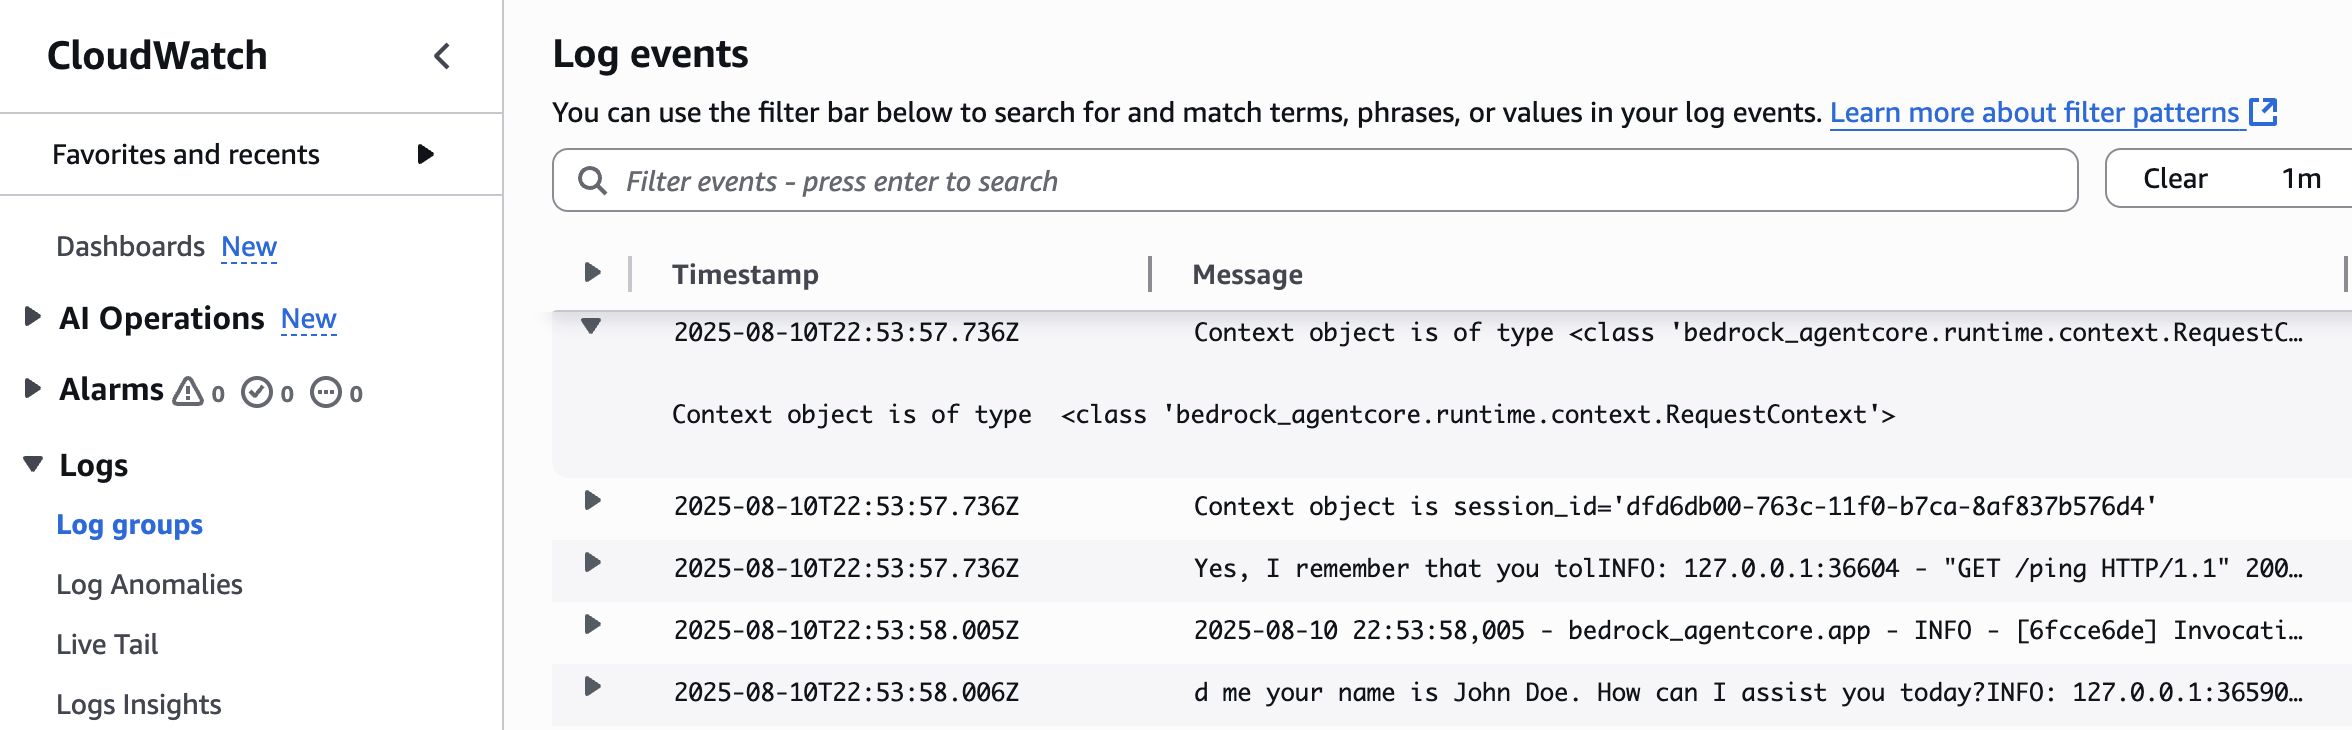